In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tidy3d as td
import os

from Devices import NanobeamSimulation
from tidy3d_utilities import FDTD_utilities
from Optimize_designs import Optimize, plotting_log_file

utilities = FDTD_utilities()

In [2]:
#TODO: add function to see the cost of whole simulation

In [2]:
def loss_function(quality_factor, Q_target):
    return (np.pi / 4 - np.arctan(quality_factor / Q_target))**2


def objective_function(params, *args):

    optimize_holes = args[0][0]
    verbose = args[0][1]

    # Reshape parameters
    if (optimize_holes):
        reshaped_params = params.reshape(2, -1).tolist()
    else:
        reshaped_params = [
            params.tolist(), nanobeam_design_options['hole_optimization_parameters'][1]
        ]

    nanobeam_design_options['hole_optimization_parameters'] = reshaped_params

    (quality_factor, resonance_wavelength, quality_factor_array,
     resonance_wavelength_array) = nanobeam.calculate_gradient(
         nanobeam_design_options,
         simulation_options,
         delta=delta,
         optimize_holes=optimize_holes,
         verbose=verbose)

    quality_factor_history.append(quality_factor)
    resonance_wavelength_history.append(resonance_wavelength)

    objective = loss_function(quality_factor, Q_target)
    loss_val = loss_function(quality_factor_array, Q_target)

    gradients = (loss_val[:, 0] - loss_val[:, 1]) / (2 * delta)

    return objective, gradients

In [ ]:
num_holes_optimize = 4
# hole_optimization_parameters = [
#     (np.random.rand(num_holes_optimize)).tolist(),
#     (np.random.rand(num_holes_optimize)).tolist()
# ]
hole_optimization_parameters = [
    np.zeros(num_holes_optimize).tolist(),
    np.zeros(num_holes_optimize).tolist(),
]
nanobeam_design_options = {
    'spacer': 335e-3,
    'alattice': 0.21,
    'slab_dimensions': [td.inf, 0.300, 0.19],
    'acenter': 0.19,
    'radius_ratio': 0.35,
    'num_holes_optimize': num_holes_optimize,
    'hole_optimization_parameters': hole_optimization_parameters,
    'num_holes_right': 8,
}

nanobeam = NanobeamSimulation(wavelength_in_at="950", **nanobeam_design_options)

simulation_options = {
    'run_time': 12,
    'sim_size': [7.5, 3, 3],
    'mesh_grid_size': 18,
    'plot_bool': False,
    'FieldMonitor_bool': False
}

td.config.logging_level = "ERROR"
opt = Optimize(objective_function=objective_function)
pstart = np.ravel(hole_optimization_parameters[0])
bounds = (-20e-3, 20e-3)

Q_target = 1e5
delta = 2e-3
quality_factor_history = []
resonance_wavelength_history = []
adam_step_size = 5e-3
Nepochs = 15
optimize_holes = False
verbose = False

log_file_name = rf"Nanobeam_950nm_weights/Nanobeam_950nm_num_holes_{nanobeam_design_options['num_holes_optimize']}"\
    f"_spacer_{nanobeam_design_options['spacer']}"\
    f"_8_holes_right"\
    f"_alattice_{nanobeam_design_options['alattice']}"\
    f"_acenter_{nanobeam_design_options['acenter']}"\
    f"_radius_ratio_{nanobeam_design_options['radius_ratio']}"\
    f"_slab_width_{nanobeam_design_options['slab_dimensions'][1]}"\
    f"_optimize_holes_{optimize_holes}"\
    f"_Q_target_{np.log10(Q_target)}_delta_{delta*1e3}"\
    f"_adam_step_size_{adam_step_size*1e3}.npy"

In [14]:
(p_opt, loss_function_history, param_history,
 t_elapsed_history) = opt.adam(pstart,
                               step_size=adam_step_size,
                               Nepochs=Nepochs,
                               bounds=bounds,
                               args=(optimize_holes, verbose))

Cavity Resonance at 939.22 nm; Q = 11132.0
Epoch:    1/  15 | Duration:  74.99 secs | Objective: 4.550006e-01
Cavity Resonance at 934.17 nm; Q = 4915.0
Epoch:    2/  15 | Duration: 213.75 secs | Objective: 5.421196e-01
Cavity Resonance at 933.38 nm; Q = 16265.0
Epoch:    3/  15 | Duration: 212.18 secs | Objective: 3.895809e-01
Cavity Resonance at 932.11 nm; Q = 8680.0
Epoch:    4/  15 | Duration: 228.56 secs | Objective: 4.883496e-01
Cavity Resonance at 932.77 nm; Q = 12086.0
Epoch:    5/  15 | Duration: 243.35 secs | Objective: 4.423834e-01
Cavity Resonance at 932.92 nm; Q = 16874.0
Epoch:    6/  15 | Duration: 236.42 secs | Objective: 3.822100e-01
Cavity Resonance at 932.57 nm; Q = 13334.0
Epoch:    7/  15 | Duration: 207.81 secs | Objective: 4.261943e-01
Cavity Resonance at 932.31 nm; Q = 15530.0
Epoch:    8/  15 | Duration: 228.98 secs | Objective: 3.985701e-01
Cavity Resonance at 931.96 nm; Q = 21541.0
Epoch:    9/  15 | Duration: 182.10 secs | Objective: 3.285970e-01
Cavity Reson

In [15]:
param_history, loss_function_history, t_elapsed_history = \
    np.array(param_history), np.array(loss_function_history), np.array(t_elapsed_history)
param_history = param_history.flatten()
loss_function_history = loss_function_history.flatten()
t_elapsed_history = t_elapsed_history.flatten()
quality_factor_history = np.asarray(quality_factor_history).flatten()
resonance_wavelength_history = np.asarray(resonance_wavelength_history).flatten()

data_to_save = np.asarray([param_history, loss_function_history, t_elapsed_history, \
    resonance_wavelength_history, quality_factor_history], dtype = 'object')

np.save(log_file_name, data_to_save)

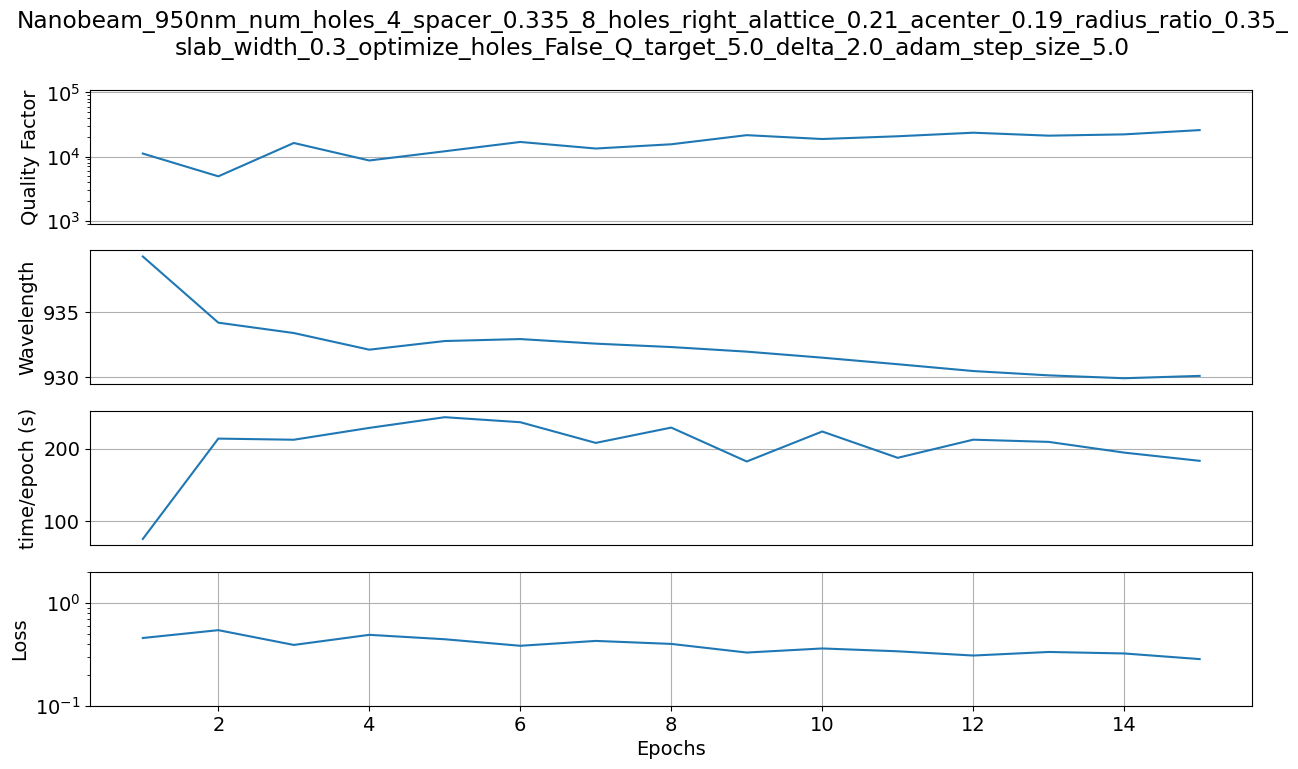

In [16]:
plotting_log_file(log_file_name)

In [17]:
p_opt * 1e3

array([ -0.63773654,  -4.99120573, -11.84728204,  -7.96354979])

In [ ]:
np.asarray([4.16979393, -3.31528533, -13.76413207, -18.22226946, -8.12099198]) / 10

array([ 0.41697939, -0.33152853, -1.37641321, -1.82222695, -0.8120992 ])